In [34]:
import sys

PWD = '..'
sys.path.append(PWD)

import numpy as np
from scipy import signal
from scipy.ndimage import filters

from matplotlib import pyplot as plt

from src.plot_utils import plot_sample
from src.cfd import CFD
from statsmodels.stats.weightstats import DescrStatsW

from scipy.stats import norm
import matplotlib.mlab as mlab

In [2]:
TIME_STEP = 1.5625e-10
BEST_CHANNEL = 17

# Load data

In [3]:
file_name = 'Ntuple_runsampic_166_runtelescope_643_filtered.npz'
all_events = np.load(f'{PWD}/data/{file_name}', allow_pickle=True)['arr_0'].flat[0]

all_events.keys()

dict_keys([17])

In [4]:
events = all_events[BEST_CHANNEL]

events.keys()

dict_keys(['sample_ampl', 'sample_channel', 'sample_t0', 'eventIDSampic'])

# Tests

In [205]:
selected_events = [0, 3243, 1000, 2000, 3000, 4000, 4500, 5000]

cfd = CFD(fraction=0.2)

In [206]:
def calculate_event_cfd(i_event, shift=False, log=False):
    event_ampl = events['sample_ampl'][i_event]

    event_cfd_timestamps = []
    for i in range(len(event_ampl)):
        ampl = event_ampl[i]

        # if log:
            # print('    sample', i)
        timestamp = cfd.predict(ampl, log=log)
        event_cfd_timestamps.append(timestamp)
        
    event_cfd_timestamps = np.array(event_cfd_timestamps)
    
    if shift:
        event_cfd_timestamps *= TIME_STEP
        
        event_t0 = events['sample_t0'][i_event]
        event_cfd_timestamps += event_t0

    return event_cfd_timestamps

<Figure size 1440x504 with 0 Axes>

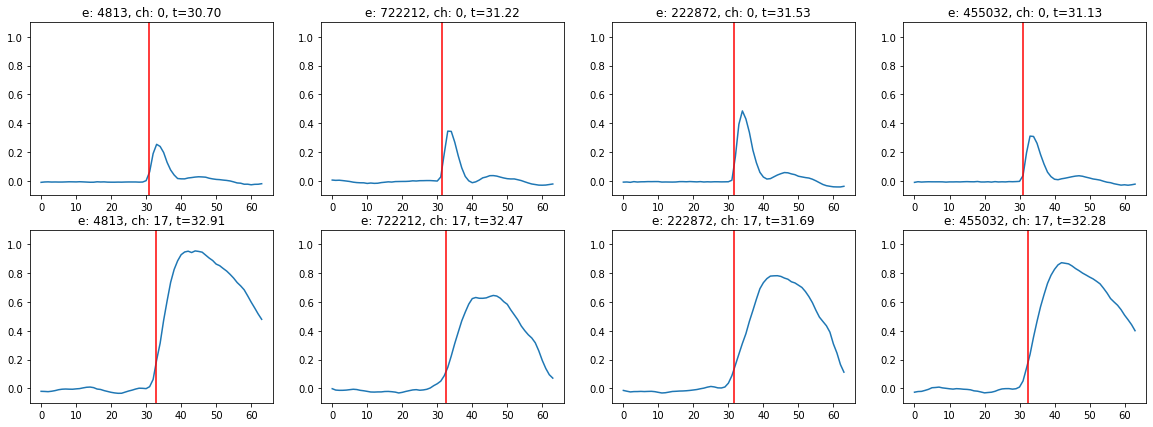

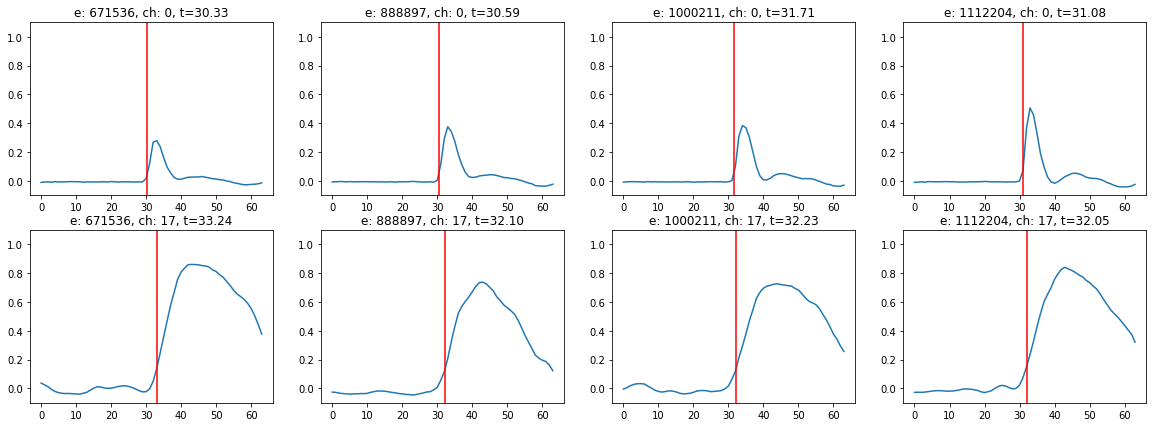

In [207]:
plt.figure(figsize=(20, 7))
for i, i_event in enumerate(selected_events):
    if i % 4 == 0:
        plt.figure(figsize=(20, 7))

    event_channels = events['sample_channel'][i_event]
    event_ampl = events['sample_ampl'][i_event]
    # print(event_time)
    
    # print('event', i)
    event_cfd_timestamps = calculate_event_cfd(i_event)
    
    for j in range(2):
        plt.subplot(2, 4, j * 4 + i % 4 + 1)
        sampic_event = events['eventIDSampic'][i_event]
        plot_sample(event_ampl[j], title=f'e: {sampic_event}, ch: {event_channels[j]}', timestamp=event_cfd_timestamps[j], ylim=True)

    if i % 4 == 3:
        plt.show()
        print('=' * 170)

# Timestamp difference

In [174]:
events['sample_t0'][3243][1] - events['sample_t0'][3243][0]

-7.968765203258954e-09

In [188]:
from scipy.optimize import curve_fit

def gauss(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def test_cfd_diff(cfd: CFD, show=True):
    timestamps = np.array([calculate_event_cfd(i, shift=True, log=True) for i in range(N)])
    timestamps_diff = timestamps[:, 1] - timestamps[:, 0]
    # print(np.argmin(timestamps_diff), timestamps_diff[np.argmin(timestamps_diff)])
    hist_data = plt.hist(timestamps_diff, bins=100, range=(-0.5e-09, 1.5e-9))
    
    # retrieve bins
    bins_x = hist_data[1][:-1]
    x_step = bins_x[1] - bins_x[0]
    bins_x += x_step
    bins_y = hist_data[0]
        
    # calculate statistics
    weighted_stats = DescrStatsW(bins_x, weights=bins_y, ddof=0)
    
    mean_stat = weighted_stats.mean
    std_stat = weighted_stats.std
        
    # retrieve statistic from a fitted gauss
    popt, _ = curve_fit(gauss, bins_x, bins_y, p0=[1, mean_stat, std_stat])
    gauss_mean = popt[1]
    gauss_std = abs(popt[2])
    
    gauss_y = norm.pdf(bins_x, gauss_mean, gauss_std)
    gauss_y *= np.max(bins_y) / np.max(gauss_y)
    plt.plot(bins_x, gauss_y, 'r--', linewidth=2)
                                                         
    if show:
        plt.show()
        
    return mean_stat, std_stat, gauss_mean, gauss_std

3243 -7.654534783796407e-09


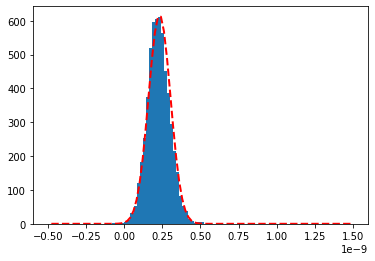

Gauss: 2.3079e-10 +- 7.2390e-11 (Data: 2.3477e-10 +- 7.3667e-11)


In [176]:
cfd = CFD(fraction=0.3)
res = test_cfd_diff(cfd)
print(f'Gauss: {res[2]:0.4e} +- {res[3]:0.4e} (Data: {res[0]:0.4e} +- {res[1]:0.4e})')

3243 -7.1599970397073776e-09


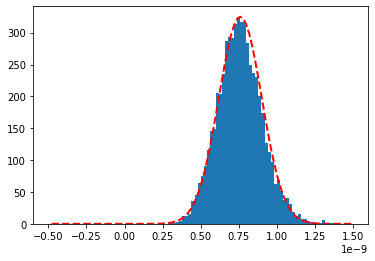

Gauss: 7.6094e-10 +- 1.4155e-10 (Data: 7.6778e-10 +- 1.4637e-10)


In [177]:
cfd = CFD(fraction=0.8)
res = test_cfd_diff(cfd)
print(f'Gauss: {res[2]:0.4e} +- {res[3]:0.4e} (Data: {res[0]:0.4e} +- {res[1]:0.4e})')

3243 -7.98252131062327e-09


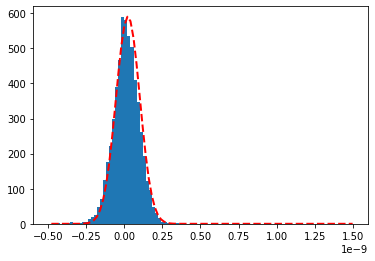

Gauss: 2.3290e-11 +- 7.8574e-11 (Data: 2.1663e-11 +- 8.3964e-11)


In [178]:
cfd = CFD(fraction=0.1)
res = test_cfd_diff(cfd)
print(f'Gauss: {res[2]:0.4e} +- {res[3]:0.4e} (Data: {res[0]:0.4e} +- {res[1]:0.4e})')

# Find best fraction

In [203]:
cfd = CFD()
std=[]
x_range = np.arange(0.05,0.9,0.05)

for i in x_range:
    cfd.fraction=i
    results = test_cfd_diff(cfd,show = False)
    std.append(results[3])
    plt.close()
    
std = np.array(std)
best_idx = np.argmin(std)
print(x_range[best_idx], std[best_idx])

0.2 7.025312234340378e-11


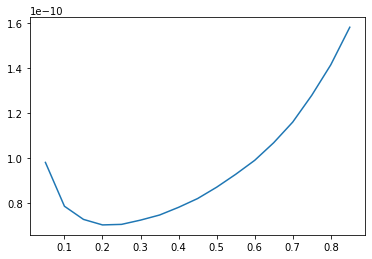

In [204]:
plt.plot(x_range, std)

# Timestamp distributions

In [15]:
all_timestamps = np.zeros((len(events['sample_channel']), 2))
all_timestamps.shape

(11702, 2)

In [16]:
for i in range(len(all_timestamps)):
    all_timestamps[i] = calculate_event_cfd(i)

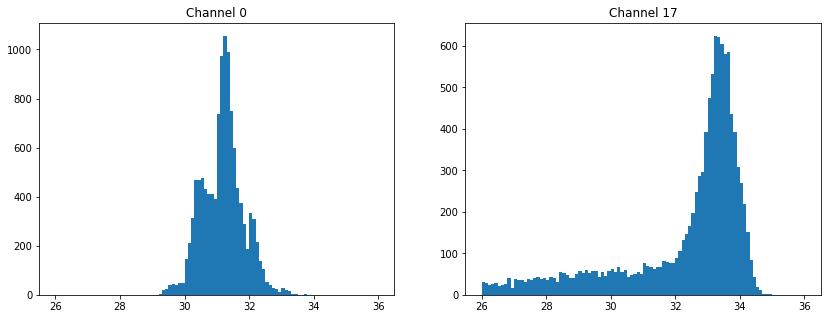

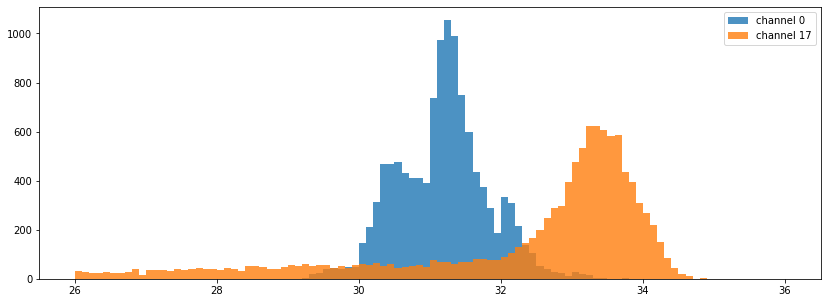

In [18]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(all_timestamps[:, 0], bins=100, range=(26, 36))
plt.title('Channel 0')

plt.subplot(1, 2, 2)
plt.hist(all_timestamps[:, 1], bins=100, range=(26, 36))
plt.title(f'Channel {BEST_CHANNEL}')

plt.show()

plt.figure(figsize=(14, 5))
plt.hist(all_timestamps[:, 0], bins=100, range=(26, 36), label='channel 0', alpha=0.8)
plt.hist(all_timestamps[:, 1], bins=100, range=(26, 36), label=f'channel {BEST_CHANNEL}', alpha=0.8)
plt.legend()
plt.show()